In [ ]:
import tensorflow as tf
print(tf.__version__)

2.17.1


In [ ]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [ ]:
import os
import zipfile
import random
import shutil
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from shutil import copyfile
import matplotlib.pyplot as plt
import matplotlib.image as mping
import numpy as np
import urllib.request
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from keras.models import Model

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Datagen

In [ ]:
import os
import shutil
from sklearn.model_selection import train_test_split

# Direktori asli
dataset_dir = '/content/drive/MyDrive/datasetnew123'
output_dir = '/content/drive/MyDrive/dataset_split1'

# Buat folder baru untuk train, val, test
os.makedirs(os.path.join(output_dir, 'train'), exist_ok=True)
os.makedirs(os.path.join(output_dir, 'val'), exist_ok=True)
os.makedirs(os.path.join(output_dir, 'test'), exist_ok=True)

for class_name in os.listdir(dataset_dir):
    class_dir = os.path.join(dataset_dir, class_name)
    if not os.path.isdir(class_dir):
        continue

    # Dapatkan semua file
    files = os.listdir(class_dir)

    # Bagi menjadi train, val, test
    train_files, temp_files = train_test_split(files, test_size=0.2, random_state=42)
    val_files, test_files = train_test_split(temp_files, test_size=0.2, random_state=42)

    # Pindahkan file ke folder
    for file_set, folder in [(train_files, 'train'), (val_files, 'val'), (test_files, 'test')]:
        class_output_dir = os.path.join(output_dir, folder, class_name)
        os.makedirs(class_output_dir, exist_ok=True)
        for file_name in file_set:
            shutil.copy(os.path.join(class_dir, file_name), os.path.join(class_output_dir, file_name))


In [ ]:
# Set the directories for training, validation, and testing data
train_dir = '/content/drive/MyDrive/dataset_split1/train'
valid_dir = '/content/drive/MyDrive/dataset_split1/val'
test_dir = '/content/drive/MyDrive/dataset_split1/test'

# Image Augmentation (excluding flip)
train_datagen = ImageDataGenerator(
    rescale=1./255
    )


val_test_datagen = ImageDataGenerator(rescale=1./255)

# Step 3: Buat Generator untuk Training, Validation, dan Testing
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),      # Ukuran gambar
    batch_size=64,               # Ukuran batch
    class_mode='categorical'     # Format label one-hot encoding
)

val_generator = val_test_datagen.flow_from_directory(
    valid_dir,
    target_size=(150, 150),
    batch_size=64,
    class_mode='categorical'
)

test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=64,
    class_mode='categorical',
    shuffle=False
)

Found 2160 images belonging to 18 classes.
Found 432 images belonging to 18 classes.
Found 108 images belonging to 18 classes.


# Model CNN

In [ ]:
# Model Definition
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.Conv2D(256, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(18, activation='softmax')  # Adjust output for your number of classes
])


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 148, 148, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 72, 72, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 34, 34, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 17, 17, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 15, 15, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 13, 13, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 6, 6, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 6, 6, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 9216)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │       4,719,104 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 18)                  │           9,234 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,526,994 (21.08 MB)

 Trainable params: 5,526,994 (21.08 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
class MyCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('accuracy') > 0.99 and logs.get('val_accuracy') > 0.97:
            print("\nReached 90% training accuracy and 95% validation accuracy so cancelling training!")
            self.model.stop_training = True

In [ ]:
history = model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=50,
        callbacks=[MyCallback()]
    )

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


34/34 ━━━━━━━━━━━━━━━━━━━━ 21s 413ms/step - accuracy: 0.2789 - loss: 2.2925 - val_accuracy: 0.8264 - val_loss: 0.4808
Epoch 2/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 13s 320ms/step - accuracy: 0.8710 - loss: 0.4040 - val_accuracy: 0.9051 - val_loss: 0.3155
Epoch 3/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 21s 327ms/step - accuracy: 0.9263 - loss: 0.2213 - val_accuracy: 0.9097 - val_loss: 0.3000
Epoch 4/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 21s 334ms/step - accuracy: 0.9554 - loss: 0.1673 - val_accuracy: 0.9259 - val_loss: 0.2211
Epoch 5/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 13s 329ms/step - accuracy: 0.9589 - loss: 0.1284 - val_accuracy: 0.9491 - val_loss: 0.2148
Epoch 6/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 21s 334ms/step - accuracy: 0.9675 - loss: 0.1035 - val_accuracy: 0.9468 - val_loss: 0.2544
Epoch 7/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 13s 328ms/step - accuracy: 0.9843 - loss: 0.0678 - val_accuracy: 0.9514 - val_loss: 0.2053
Epoch 8/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 20s 329ms/step - accuracy: 0.9891 - loss: 0.0314 - val_accuracy: 0.956

In [ ]:
model.save('ModelCNN9.h5')

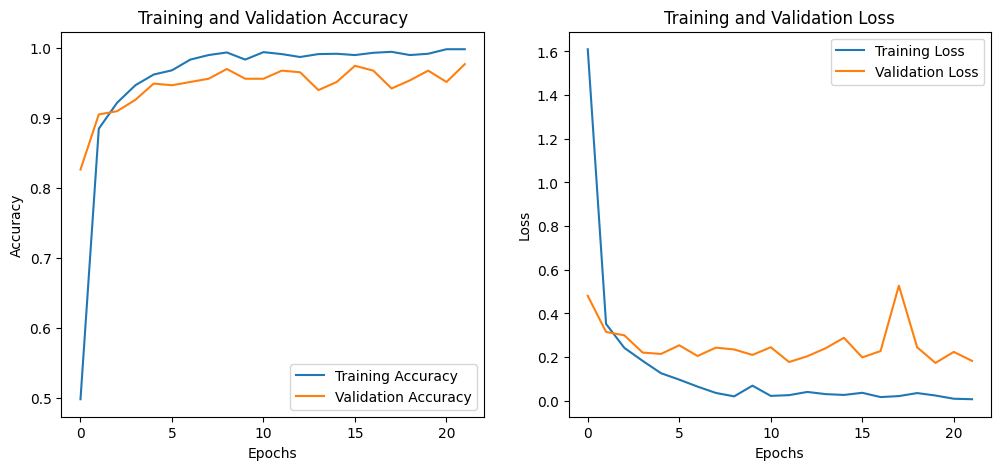

In [ ]:

# Plot training & validation accuracy/loss values
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()



2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 235ms/step


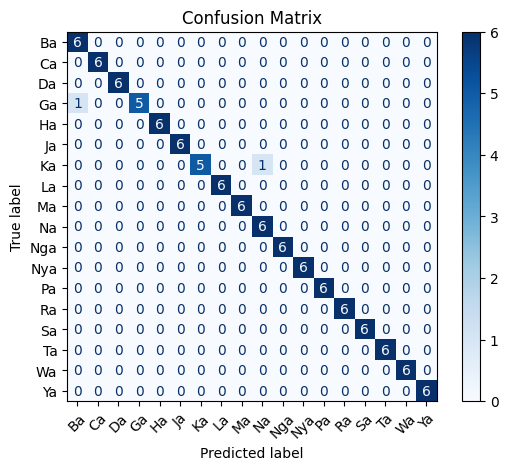

Classification Report:
              precision    recall  f1-score   support

          Ba       0.86      1.00      0.92         6
          Ca       1.00      1.00      1.00         6
          Da       1.00      1.00      1.00         6
          Ga       1.00      0.83      0.91         6
          Ha       1.00      1.00      1.00         6
          Ja       1.00      1.00      1.00         6
          Ka       1.00      0.83      0.91         6
          La       1.00      1.00      1.00         6
          Ma       1.00      1.00      1.00         6
          Na       0.86      1.00      0.92         6
         Nga       1.00      1.00      1.00         6
         Nya       1.00      1.00      1.00         6
          Pa       1.00      1.00      1.00         6
          Ra       1.00      1.00      1.00         6
          Sa       1.00      1.00      1.00         6
          Ta       1.00      1.00      1.00         6
          Wa       1.00      1.00      1.00         6
    

In [ ]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Dapatkan prediksi pada data uji
test_generator.reset()  # Pastikan generator dimulai dari awal
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)  # Ambil label dengan probabilitas tertinggi

# Ambil label sebenarnya
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())  # Label kelas

# Confusion Matrix
cm = confusion_matrix(true_classes, predicted_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title("Confusion Matrix")
plt.show()

# Classification Report (Precision, Recall, F1 Score)
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print("Classification Report:")
print(report)


# Model ResNet

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D, Input
from tensorflow.keras.optimizers import Adam

In [ ]:
# Create a ResNet50 model
input_shape = (150, 150, 3)
resnet = ResNet50(include_top=False, weights='imagenet', input_tensor=Input(shape=input_shape))

# Freeze the layers of ResNet50
for layer in resnet.layers:
    layer.trainable = False

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:
# Add custom layers on top of ResNet50
x = Flatten()(resnet.output)
x = Dense(512, activation='relu')(x)
x = Dense(512, activation='relu')(x)
x = Dense(128, activation='relu')(x)
x = Dense(128, activation='relu')(x)
output = Dense(18, activation='softmax')(x)

model = Model(inputs=resnet.input, outputs=output)

In [ ]:
# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
class MyCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('accuracy') > 0.99 and logs.get('val_accuracy') > 0.97:
            print("\nReached 90% training accuracy and 95% validation accuracy so cancelling training!")
            self.model.stop_training = True

In [ ]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=50,
    callbacks=[MyCallback()]

)

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


34/34 ━━━━━━━━━━━━━━━━━━━━ 877s 21s/step - accuracy: 0.2297 - loss: 2.5981 - val_accuracy: 0.7269 - val_loss: 0.8753
Epoch 2/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 66s 345ms/step - accuracy: 0.8489 - loss: 0.5264 - val_accuracy: 0.9074 - val_loss: 0.2896
Epoch 3/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 20s 341ms/step - accuracy: 0.9528 - loss: 0.1698 - val_accuracy: 0.9144 - val_loss: 0.2749
Epoch 4/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 21s 346ms/step - accuracy: 0.9636 - loss: 0.1241 - val_accuracy: 0.9236 - val_loss: 0.2038
Epoch 5/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 21s 348ms/step - accuracy: 0.9674 - loss: 0.1052 - val_accuracy: 0.9653 - val_loss: 0.1242
Epoch 6/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 14s 341ms/step - accuracy: 0.9857 - loss: 0.0493 - val_accuracy: 0.9468 - val_loss: 0.1746
Epoch 7/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 14s 342ms/step - accuracy: 0.9937 - loss: 0.0328 - val_accuracy: 0.9514 - val_loss: 0.1591
Epoch 8/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 20s 343ms/step - accuracy: 0.9867 - loss: 0.0371 - val_accuracy: 0.9444

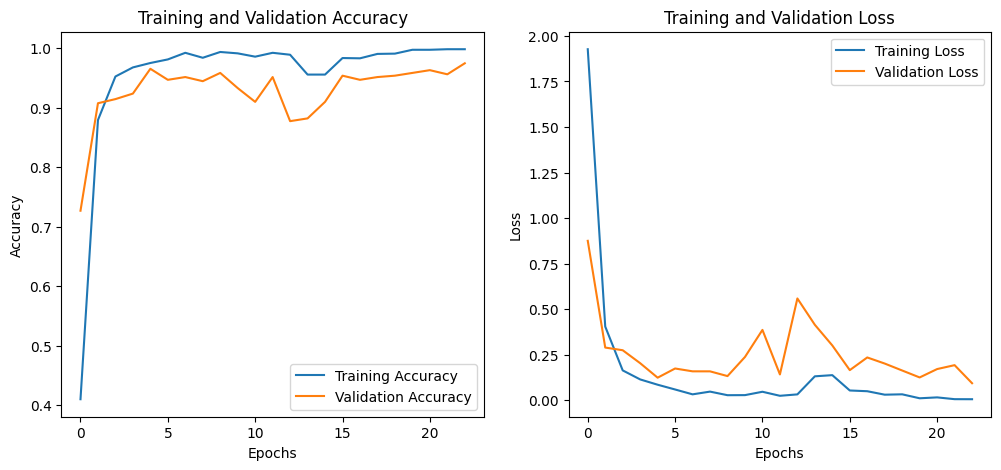

In [ ]:

# Plot training & validation accuracy/loss values
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()



2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 6s/step


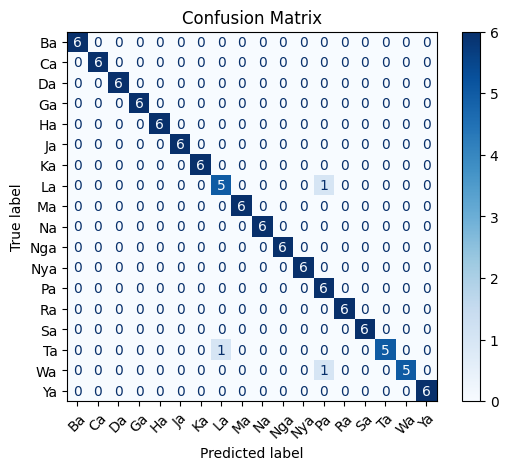

Classification Report:
              precision    recall  f1-score   support

          Ba       1.00      1.00      1.00         6
          Ca       1.00      1.00      1.00         6
          Da       1.00      1.00      1.00         6
          Ga       1.00      1.00      1.00         6
          Ha       1.00      1.00      1.00         6
          Ja       1.00      1.00      1.00         6
          Ka       1.00      1.00      1.00         6
          La       0.83      0.83      0.83         6
          Ma       1.00      1.00      1.00         6
          Na       1.00      1.00      1.00         6
         Nga       1.00      1.00      1.00         6
         Nya       1.00      1.00      1.00         6
          Pa       0.75      1.00      0.86         6
          Ra       1.00      1.00      1.00         6
          Sa       1.00      1.00      1.00         6
          Ta       1.00      0.83      0.91         6
          Wa       1.00      0.83      0.91         6
    

In [ ]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Dapatkan prediksi pada data uji
test_generator.reset()  # Pastikan generator dimulai dari awal
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)  # Ambil label dengan probabilitas tertinggi

# Ambil label sebenarnya
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())  # Label kelas

# Confusion Matrix
cm = confusion_matrix(true_classes, predicted_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title("Confusion Matrix")
plt.show()

# Classification Report (Precision, Recall, F1 Score)
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print("Classification Report:")
print(report)


In [ ]:
model.save('ModelResNet1.h5')

In [ ]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=50,
    callbacks=[MyCallback()]

)

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


34/34 ━━━━━━━━━━━━━━━━━━━━ 31s 553ms/step - accuracy: 0.1718 - loss: 2.8420 - val_accuracy: 0.6505 - val_loss: 1.0640
Epoch 2/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 31s 345ms/step - accuracy: 0.8015 - loss: 0.6752 - val_accuracy: 0.8796 - val_loss: 0.3961
Epoch 3/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 14s 342ms/step - accuracy: 0.9463 - loss: 0.2172 - val_accuracy: 0.8912 - val_loss: 0.3252
Epoch 4/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 14s 337ms/step - accuracy: 0.9469 - loss: 0.1680 - val_accuracy: 0.9444 - val_loss: 0.1782
Epoch 5/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 21s 343ms/step - accuracy: 0.9787 - loss: 0.0726 - val_accuracy: 0.9514 - val_loss: 0.1552
Epoch 6/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 14s 343ms/step - accuracy: 0.9899 - loss: 0.0446 - val_accuracy: 0.9699 - val_loss: 0.1356
Epoch 7/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 20s 337ms/step - accuracy: 0.9918 - loss: 0.0300 - val_accuracy: 0.9630 - val_loss: 0.1254
Epoch 8/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 21s 337ms/step - accuracy: 0.9982 - loss: 0.0160 - val_accuracy: 0.960

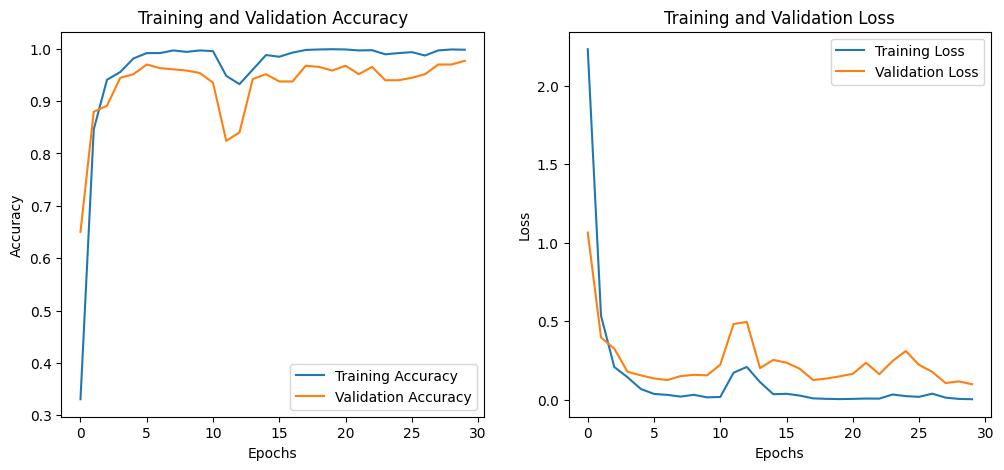

In [ ]:

# Plot training & validation accuracy/loss values
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()



In [ ]:
model.save('Modelresnet2.h5')

2/2 ━━━━━━━━━━━━━━━━━━━━ 10s 6s/step


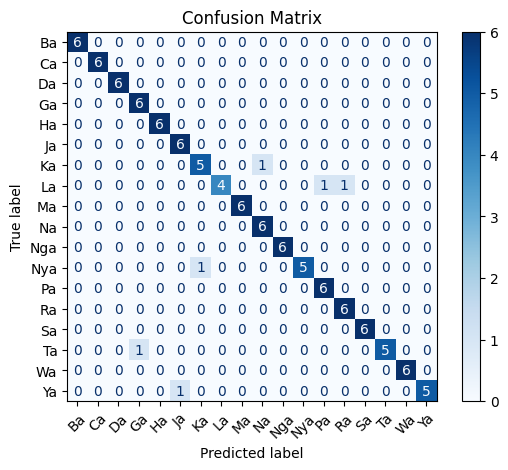

Classification Report:
              precision    recall  f1-score   support

          Ba       1.00      1.00      1.00         6
          Ca       1.00      1.00      1.00         6
          Da       1.00      1.00      1.00         6
          Ga       0.86      1.00      0.92         6
          Ha       1.00      1.00      1.00         6
          Ja       0.86      1.00      0.92         6
          Ka       0.83      0.83      0.83         6
          La       1.00      0.67      0.80         6
          Ma       1.00      1.00      1.00         6
          Na       0.86      1.00      0.92         6
         Nga       1.00      1.00      1.00         6
         Nya       1.00      0.83      0.91         6
          Pa       0.86      1.00      0.92         6
          Ra       0.86      1.00      0.92         6
          Sa       1.00      1.00      1.00         6
          Ta       1.00      0.83      0.91         6
          Wa       1.00      1.00      1.00         6
    

In [ ]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Dapatkan prediksi pada data uji
test_generator.reset()  # Pastikan generator dimulai dari awal
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)  # Ambil label dengan probabilitas tertinggi

# Ambil label sebenarnya
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())  # Label kelas

# Confusion Matrix
cm = confusion_matrix(true_classes, predicted_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title("Confusion Matrix")
plt.show()

# Classification Report (Precision, Recall, F1 Score)
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print("Classification Report:")
print(report)


Saving WhatsApp Image 2024-12-11 at 19.01.03_9a91e681.jpg to WhatsApp Image 2024-12-11 at 19.01.03_9a91e681.jpg


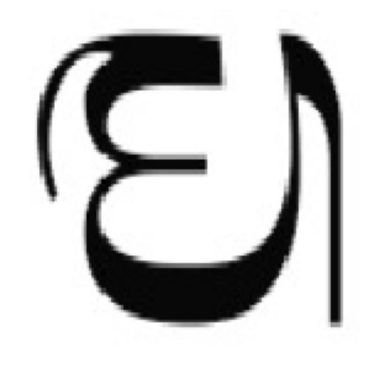

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step
Image: WhatsApp Image 2024-12-11 at 19.01.03_9a91e681.jpg
Predicted Class: Ma
Confidence: 69.78%


In [ ]:
import numpy as np
from tensorflow.keras.preprocessing import image
from google.colab import files
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

# Load the label mapping from train_generator
labels = {value: key for key, value in train_generator.class_indices.items()}

# Load the trained model
saved_model = load_model("ModelCNN9.h5")

# Upload an image
uploaded = files.upload()

for fn in uploaded.keys():
    # Load and preprocess the image
    path = fn
    img = image.load_img(path, target_size=(150, 150))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x /= 255.0  # Scale as per training

    # Display the image
    plt.imshow(img)
    plt.axis('off')
    plt.show()

    # Make prediction
    predictions = saved_model.predict(x)
    predicted_class_index = np.argmax(predictions, axis=1)[0]
    predicted_class_label = labels[predicted_class_index]
    confidence = np.max(predictions) * 100

    # Display prediction results
    print(f"Image: {fn}")
    print(f"Predicted Class: {predicted_class_label}")
    print(f"Confidence: {confidence:.2f}%")
